Questions:
- Is there a difference between ProtoScript and ProtoScript II?
- Currently, we don't use FM150 because caps have slightly different naming: `['ppp - SUBOPT', 'NAD - SUBOPT', 'Ap4A - SUBOPT', 'm7Gp3A - SUBOPT', 'TMG - SUBOPT', 'TMG - NORMAL', 'OH - NORMAL', 'ppp - TAT', 'NAD - TAT', 'Ap4A - TAT', 'm7Gp3A - TAT']`. Should we use only "NORMAL" caps or also the "TAT" caps? We shoudn't use "SUBOPT", right?
- Fingerprints for FM156 are missing in all version of the fingerprint databases from Nikolas. Is it expected?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

## Pre-process fingerprints

In [9]:
# Combine all fingerprint databases
df = pd.concat([
    pd.read_csv('../nik_flaminia_project_share/blind_testing/euclidean_distance_v2/fingerprint_database_v1.csv'),
    pd.read_csv('../nik_flaminia_project_share/blind_testing/euclidean_distance_v2/fingerprint_database_v2.csv'),
    pd.read_csv('../nik_flaminia_project_share/blind_testing/euclidean_distance_v2/fingerprint_database_v3.csv')
])

display(df[df['experiment'] == 138])

# Choose only relevant RTs
df['RT name'] = df['RT name'].str.upper()
df = df[df['RT name'].isin(['INDURO', 'PROTOSCRIPT II', 'MARATHON', 'GOSCRIPT', 'EPISCRIPT'])]

# Choose only relevant caps
df['cap'] = df['cap'].str.upper()
df['cap'] = df['cap'].replace({'M⁷GP₃A': 'M7GP3A', 'AP₄A': 'AP4A'})
df = df[df['cap'].isin(['NAD', 'AP4A', 'M7GP3A', 'TMG'])]

# Drop duplicated experiment-barcode-RT-cap combinations
df = df.drop_duplicates(subset=['RT name', 'cap', 'barcode', 'experiment'])

# Use only barcodes BP06 and BP12 from experiment FM138
df = df[(df['experiment'] != 'FM138') | (df['barcode'].isin(['BP06', 'BP12']))]

# Exclude AUA experiment FM142 for now
df = df[df['experiment'] != 'FM142']

# Use experiments FM135 and FM155 for validation and testing
val_experiment = 'FM135'
test_experiment = 'FM155'
df_train = df[~df['experiment'].isin([val_experiment, test_experiment])].reset_index(drop=True)
df_train.attrs['name'] = 'train'
df_val = df[df['experiment'] == val_experiment].reset_index(drop=True)
df_val.attrs['name'] = 'val (FM135)'
df_test = df[df['experiment'] == test_experiment].reset_index(drop=True)
df_test.attrs['name'] = 'test (FM155)'

print("RT name counts:")
display(df_train['RT name'].value_counts())
print("\nCap counts:")
display(df_train['cap'].value_counts())
print("\nTotal number of samples:", len(df_train))

,RT name,cap,barcode,experiment,A%,C%,G%,T%,%adj_A,%adj_C,%adj_G,%adj_T,%adj_DEL,%adj_INS


RT name counts:


RT name
EPISCRIPT         4
GOSCRIPT          4
INDURO            3
PROTOSCRIPT II    3
MARATHON          3
Name: count, dtype: int64


Cap counts:


cap
NAD       5
AP4A      5
M7GP3A    5
TMG       2
Name: count, dtype: int64


Total number of samples: 17


In [14]:
df[df['experiment'] == 'FM135']

,RT name,cap,barcode,experiment,A%,C%,G%,T%,%adj_A,%adj_C,%adj_G,%adj_T,%adj_DEL,%adj_INS
28,INDURO,NAD,BP02,FM135,54.760581,23.976283,6.662432,14.600704,20.415655,8.938757,2.483865,5.443385,59.056190,3.662147
31,INDURO,AP4A,BP03,FM135,40.189637,28.270814,10.355153,21.184397,13.245251,9.317179,3.412735,6.981717,63.574189,3.468929
34,INDURO,M7GP3A,BP04,FM135,38.480004,32.385978,13.096155,16.037864,16.090147,13.541972,5.476066,6.706122,53.912220,4.273472
40,PROTOSCRIPT II,NAD,BP06,FM135,66.160271,13.605809,7.871614,12.362305,30.189659,6.208480,3.591904,5.641056,51.379216,2.989685
43,PROTOSCRIPT II,AP4A,BP07,FM135,32.541010,15.479555,4.579272,47.400163,19.144842,9.107081,2.694122,27.886923,37.772963,3.394070
46,PROTOSCRIPT II,M7GP3A,BP08,FM135,62.260210,23.037121,6.534946,8.167724,35.018809,12.957434,3.675638,4.594009,38.071422,5.682688
59,MARATHON,NAD,BP14,FM135,83.328016,4.747411,6.828822,5.095750,61.878450,3.525374,5.071007,3.784047,21.567146,4.173977
61,MARATHON,AP4A,BP15,FM135,36.729050,10.678813,9.639975,42.952162,22.564674,6.560582,5.922367,26.387874,35.581092,2.983411
63,MARATHON,M7GP3A,BP16,FM135,42.184185,30.560812,11.517289,15.737714,18.857260,13.661356,5.148482,7.035105,51.123387,4.174410


## Display the available number of cap-RT pairs

train


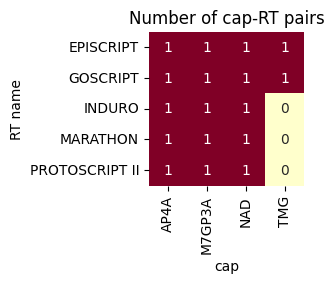

val (FM135)


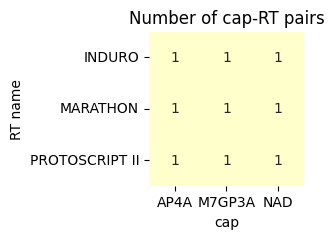

test (FM155)


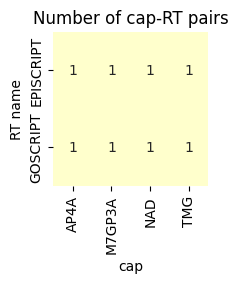

In [4]:
for df in [df_train, df_val, df_test]:
    print(df.attrs['name'])
    pair_counts = df.groupby(['RT name', 'cap']).size().unstack(fill_value=0)
    plt.figure(figsize=(2, 2))
    sns.heatmap(pair_counts, annot=True, fmt='d', cmap='YlOrRd', cbar=False)
    plt.title('Number of cap-RT pairs')
    plt.show()

## Make predictions for validation data (FM135) and for testing data (FM155) using the rest of the data as reference

In [5]:
# Get unique RT names from all datasets
all_rt_names = df_train['RT name'].unique()
all_caps = ['AP4A', 'M7GP3A', 'TMG', 'NAD']

# Function to create feature vector for each sample
def create_features(df):
    features = []
    labels = []
    
    # Group by cap type
    for cap_type, cap_group in df.groupby('cap'):
        # Initialize feature vector with zeros
        feature_vec = np.zeros(len(all_rt_names) * len(all_caps))

        # For each RT in this cap group, add its ACGT percentages
        for _, row in cap_group.iterrows():
            rt_idx = np.where(all_rt_names == row['RT name'])[0][0]
            base_idx = rt_idx * len(all_caps)
            feature_vec[base_idx:base_idx+len(all_caps)] = row[['A%', 'C%', 'G%', 'T%']]
        
        features.append(feature_vec)
        labels.append(cap_type)

    return np.array(features), np.array(labels)

# Create features and labels for each dataset
X_train, y_train = create_features(df_train)
X_val, y_val = create_features(df_val) 
X_test, y_test = create_features(df_test)

# Predict using 1-NN with cosine similarity and masked training set depending on the RTs present in the test sample
def predict(X_test_sample, X_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
    mask = X_test_sample != 0
    X_train_masked = X_train.copy()
    X_train_masked[:, ~mask] = 0  # Use only training RTs that are present in the test sample
    knn.fit(X_train_masked[:, mask], y_train)
    return knn.predict(X_test_sample[mask].reshape(1, -1))[0]

# Make predictions
val_predictions = [predict(x, X_train, y_train) for x in X_val]
test_predictions = [predict(x, X_train, y_train) for x in X_test]

# Calculate accuracies
val_accuracy = (np.array(val_predictions) == y_val).mean()
print(f"Validation accuracy: {val_accuracy:.2f}")
for true, pred in zip(y_val, val_predictions):
    print(f"True: {true:8} Predicted: {pred}")
test_accuracy = (np.array(test_predictions) == y_test).mean()
print(f"\nTest accuracy: {test_accuracy:.2f}")
for true, pred in zip(y_test, test_predictions):
    print(f"True: {true:8} Predicted: {pred}")

Validation accuracy: 1.00
True: AP4A     Predicted: AP4A
True: M7GP3A   Predicted: M7GP3A
True: NAD      Predicted: NAD

Test accuracy: 1.00
True: AP4A     Predicted: AP4A
True: M7GP3A   Predicted: M7GP3A
True: NAD      Predicted: NAD
True: TMG      Predicted: TMG
